In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

# for matplotlib colormaps:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap


In [2]:
import pythia8

# Produce leading-order events with Pythia.
pythia = pythia8.Pythia()
pythia.readString("Beams:eCM = 14000.") # Energy of collisions

# pythia.readString("WeakSingleBoson:ffbar2gmZ = on")
# pythia.readString("23:onMode = off")
# pythia.readString("23:onIfMatch = -13 13")
# pythia.readString("PhaseSpace:mHatMin = 80.")

pythia.readString("HardQCD:all = on")
pythia.readString("PhaseSpace:pTHatMin = 500."); # Filter on minimum event energy

pythia.init(); # this is a noisy line but useful to confirm how Pythia is set up

# help(pythia)

import fastjet as fj



 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.312      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 23 May 2024  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 31 Oct 2024 at 10:18:28    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

In [9]:
n_events = 1
particle_y_cut = 4.9 # cut on hadron rapidity
particle_pt_cut  = 0.5 # cut on hadron pT
min_jet_pt = 0 # cut on jet pT (was 50.0, now 0 for ghosts)

# We will want to make R=0.4 jets with various algorithms
# With ghosts, we now make R=1.0 jets to reduce visual clutter in the graph

kt_jetdef  = fj.JetDefinition(fj.kt_algorithm,        1.0) 
akt_jetdef = fj.JetDefinition(fj.antikt_algorithm,    1.0)
ca_jetdef  = fj.JetDefinition(fj.cambridge_algorithm, 1.0) # algorithm, R


In [10]:
# When running Pythia in a notebook, the first generation has to be aborted and then re-started.
# So, hit 'stop' above when this cell triggers the first time, and then move on.
pythia.next()

True

In [11]:
# Porting function to add ghosts

ghost_kt = 0.1 # some small number ?? may need to randomize ?

def add_ghosts(event):
    """ adds ghosts. takes event :: list[PseudoJet] and 
    returns event_with_ghosts :: list[PseudoJet]
    which has ghosts in a grid with random offsets """

    event_with_ghosts = event
    
    # Deal with any wrapping issues in rapidity
    # if event.fj2_placement:
    #     rap_offset = 0
    # else:
    #     rap_offset = 0.5
    
    # Set parameters: these must all have at most only two decimal points 
    #  (hundredths) due to range function adjustment
    rap_limit = 4.9
    rap_step = 0.03
    phi_limit = np.pi
    phi_step = 0.03

    # Double loop over rapidity-phi grid: python range function
    #  only takes integers, so we convert by 2 decimal places
    for irapn in range(int(-100*rap_limit), int(100*rap_limit), int(100*rap_step)):
        for iphin in range(int(-100*phi_limit), int(100*phi_limit), int(100*phi_step)):

            # fix irap, iphi values (in python 3 should 
            #  automatically convert back to float instead of flooring)
            irap = irapn/100
            iphi = iphin/100

            # Include random jitter for all quantities
            rand_drap = (np.random.rand() - 0.5) * rap_step # offset by some random between +/-0.5
            rand_dphi = (np.random.rand() - 0.5) * phi_step

            rap = irap + rand_drap
            phi = iphi + rand_dphi
            kt = ghost_kt * (1 + (np.random.rand() - 0.5))
            
            # Make the fj.PseudoJet for the ghost in question
            exprap = np.exp(+rap)
            pminus = kt / exprap
            pplus = kt * exprap
            px = kt * np.cos(phi)
            py = kt * np.sin(phi)
            
            mom = fj.PseudoJet(px, py, (pplus - pminus), (pplus + pminus))
            
            # Cache rap,phi and make sure we don't "certainly mess up our results"
            mom.set_cached_rap_phi(rap,phi)        

            # Append the ghost fj.PseudoJet to the event list
            event_with_ghosts.append(mom)

    return event_with_ghosts

In [12]:
# Generate some leading-order events ...

# We'll store the particles and jets for further study.
# In order to use them with wasserstein & sklearn, we'll use 0-padded np.arrays
    
max_n_jets = 2
max_n_particles = 200

# np.empty gives 0-pads ...

py_events_weights = np.zeros((n_events,1))
py_events_jets = np.zeros((n_events,max_n_jets,4))
py_events_particles = np.zeros((n_events,max_n_particles,3))

####################################
# Outer loop over events
####################################
for idx_event,_ in enumerate(range(n_events)):
   
    if not pythia.next():
        continue

    particles = []

    pidx=0        
    for idx,p in enumerate(pythia.event):
        if p.isFinal() and p.isHadron() and (abs(p.y()) < particle_y_cut) and (p.pT() > particle_pt_cut):                    
            
            pj = fj.PseudoJet( p.px(), p.py(), p.pz(), p.e() )
            particles.append( pj )
            
            if(pidx<max_n_particles):
                py_events_particles[idx_event, pidx, 0] = pj.pt()
                py_events_particles[idx_event, pidx, 1] = pj.eta()
                py_events_particles[idx_event, pidx, 2] = pj.phi()
            
            pidx+=1

    ### NEW: ADD GHOSTS to the particles list ###
    add_ghosts(particles)
    
    # Make the jets
    kt_cluster = fj.ClusterSequence(particles, kt_jetdef)
    akt_cluster = fj.ClusterSequence(particles, akt_jetdef)
    ca_cluster = fj.ClusterSequence(particles, ca_jetdef)
    
    # for jidx in range(0,len(fj.sorted_by_pt(akt_cluster.inclusive_jets(min_jet_pt))),1):
    #     if(jidx < max_n_jets):
    #         py_events_jets[idx_event, jidx, 0] = fj.sorted_by_pt(akt_cluster.inclusive_jets(min_jet_pt))[jidx].pt()
    #         py_events_jets[idx_event, jidx, 1] = fj.sorted_by_pt(akt_cluster.inclusive_jets(min_jet_pt))[jidx].eta()
    #         py_events_jets[idx_event, jidx, 2] = fj.sorted_by_pt(akt_cluster.inclusive_jets(min_jet_pt))[jidx].phi()
    #         py_events_jets[idx_event, jidx, 3] = fj.sorted_by_pt(akt_cluster.inclusive_jets(min_jet_pt))[jidx].m()


In [13]:
# Get the jets from each algorithm, sorted by pT
kt_jets = fj.sorted_by_pt(kt_cluster.inclusive_jets(min_jet_pt))
akt_jets = fj.sorted_by_pt(akt_cluster.inclusive_jets(min_jet_pt))
ca_jets = fj.sorted_by_pt(ca_cluster.inclusive_jets(min_jet_pt))

print("Clustered with "+kt_jetdef.description())
print("The leading jet pT is: "+str(kt_jets[0].perp())+" GeV")
print("The second jet pT is: "+str(kt_jets[1].perp())+" GeV\n")

print("Clustered with "+akt_jetdef.description())
print("The akt jet pT is: "+str(akt_jets[0].perp())+" GeV")
print("The second jet pT is: "+str(akt_jets[1].perp())+" GeV\n")

print("Clustered with "+ca_jetdef.description())
print("The CA jet pT is: "+str(ca_jets[0].perp())+" GeV")
print("The second jet pT is: "+str(ca_jets[1].perp())+" GeV\n")

Clustered with Longitudinally invariant kt algorithm with R = 1 and E scheme recombination
The leading jet pT is: 538.0091606934611 GeV
The second jet pT is: 392.9826117587877 GeV

Clustered with Longitudinally invariant anti-kt algorithm with R = 1 and E scheme recombination
The akt jet pT is: 701.138601860088 GeV
The second jet pT is: 550.7226888575942 GeV

Clustered with Longitudinally invariant Cambridge/Aachen algorithm with R = 1 and E scheme recombination
The CA jet pT is: 548.8798695952222 GeV
The second jet pT is: 464.49220189663504 GeV



In [14]:
# Let's look at the constituents for the leading jet, for the different algorithms.

In [15]:
# Creating a colormap for all algorithms

# fetch 'plasma' premade sequential colormap from matplotlib
plasma = mpl.colormaps['plasma'].resampled(8)
newcolors = plasma(np.linspace(0, 1, 8))

rainbow = mpl.colormaps['rainbow'].resampled(32)
newcolors = rainbow(np.linspace(0,1,32))

# other colormap since plasma is too gradiented
set3 = mpl.colormaps['Set3']
set2 = mpl.colormaps['Set2']

# assign final colormap
cmp = rainbow

kt jet info ... 
idx	y		phi		pt		n constituents
0 	 0.1358 	 2.3113 	 538.0092 	 2081

Constituent info:       
0 	 -0.0456 	 2.4114 	 38.5471 	
1 	 0.0254 	 2.5071 	 28.5240 	
2 	 0.0102 	 2.5239 	 21.4012 	
3 	 -0.4180 	 2.6018 	 18.0454 	
4 	 0.0093 	 2.4832 	 17.2745 	
5 	 -0.0320 	 2.4357 	 16.0870 	
6 	 0.0189 	 2.5555 	 15.8685 	
7 	 -0.2910 	 2.6562 	 13.5739 	
8 	 -0.0091 	 2.5130 	 13.4961 	
9 	 0.0723 	 2.4453 	 13.2791 	
10 	 -0.0407 	 2.4180 	 13.0575 	
11 	 -0.0457 	 2.4168 	 12.8694 	
12 	 0.1596 	 1.9167 	 12.7039 	
13 	 0.0576 	 2.5265 	 12.2788 	
14 	 -0.0034 	 2.3762 	 11.9536 	
15 	 -0.3104 	 2.6708 	 7.4582 	
16 	 -0.0697 	 2.5470 	 6.5073 	
17 	 -0.0160 	 2.5772 	 6.4864 	
18 	 -0.1115 	 2.4170 	 6.0904 	
19 	 -0.4352 	 2.4795 	 6.0798 	
20 	 -0.0207 	 2.4147 	 5.8834 	
21 	 0.0034 	 2.3563 	 5.8458 	
22 	 0.0956 	 2.4763 	 4.6410 	
23 	 0.2548 	 2.0687 	 4.6126 	
24 	 -0.1286 	 2.7572 	 4.3605 	
25 	 0.1706 	 1.9740 	 3.9210 	
26 	 0.2348 	 1.7748 	 3.9150 	
27 	

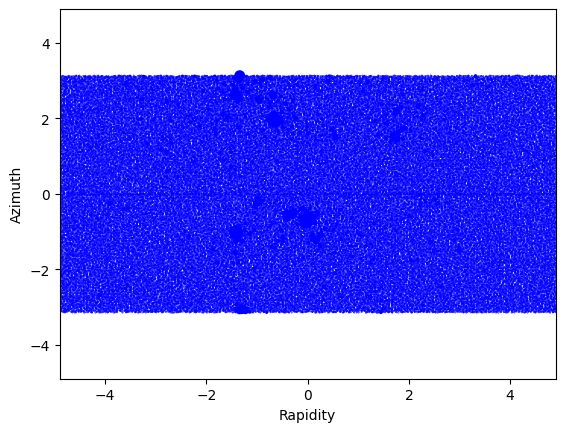

In [16]:
print("kt jet info ... ");
print("idx\ty\t\tphi\t\tpt\t\tn constituents");

# print out the details for each jet
for i in range(0,1):
    # get the constituents of the jet
    constituents = fj.sorted_by_pt(kt_jets[i].constituents())

    print(i,"\t",
          "%0.4f"%kt_jets[i].rap(), "\t",
          "%0.4f"%kt_jets[i].phi(),"\t",
          "%0.4f"%kt_jets[i].perp(),"\t",
          len(constituents))

    print("\nConstituent info:       ");
    for j in range(0,len(constituents)) :
        ### NEW: to avoid printing ghosts, check if greater than ghost cutoff
        if (constituents[j].perp() > (ghost_kt + 0.5*ghost_kt)):
            print(j,"\t",
                  "%0.4f"%constituents[j].rap(),"\t",
                  "%0.4f"%constituents[j].phi(),"\t",
                  "%0.4f"%constituents[j].perp(),"\t",
                 );

    zf = 2

    # avg_rap = sum([c.rap() for c in constituents]) / len(constituents)
    # avg_phi = sum([c.phi() for c in constituents]) / len(constituents)
    avg_rap = sum([p.rap() for p in particles]) / len(particles)
    avg_phi = sum([p.phi() for p in particles]) / len(particles) # changed to particles rather than constituents to show whole event
    
    # plt.scatter([c.rap()-avg_rap for c in constituents],
    #             [c.phi()-avg_phi for c in constituents],
    #             s=[c.perp()*zf for c in constituents],
    #             # s=[np.log(c.perp())*zf for c in constituents],
    #             color='purple')
    plt.scatter([p.rap()-avg_rap for p in particles],
                [p.phi()-avg_phi for p in particles],
                s=[p.perp()*zf for p in particles],
                # s=[np.log(c.perp())*zf for c in constituents],
                color='blue')
    
    plt.xlim(-4.9,4.9)
    plt.ylim(-4.9,4.9) # changed from 0.4 to show whole event
    plt.ylabel('Azimuth')
    plt.xlabel('Rapidity')
    plt.show()

kt jet info ... 
idx	y		phi		pt		n constituents


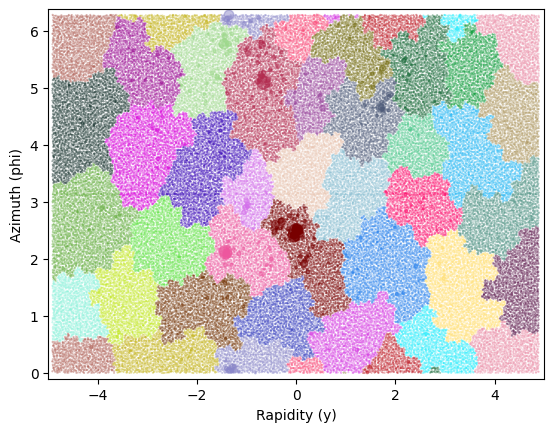

In [17]:
### color for kt

print("kt jet info ... ");
print("idx\ty\t\tphi\t\tpt\t\tn constituents");
# print("        indices of constituents\n\n");

# set first color to red
r = 0.47
g = 0
b = 0

# set first color index in colormap
# n = 0

# print out the details for each jet
for j in kt_jets:

    # set color for the current jet
    current_color = (r,g,b, 0.5)
    # current_color = cmp.colors[n%12]
    
    # get the constituents of the jet
    constituents = fj.sorted_by_pt(j.constituents())

    # add scaling factor for visibility
    zf = 2

    # compute average angles for whole event - not needed anymore
    avg_rap = sum([p.rap() for p in particles]) / len(particles)
    avg_phi = sum([p.phi() for p in particles]) / len(particles) # changed to particles rather than constituents to show whole event

    # scatter constituent particles by phi vs rapidity
    plt.scatter([c.rap() for c in constituents],
                [c.phi() for c in constituents],
                s=[c.perp()*zf for c in constituents],
                color=current_color)
    
    plt.xlim(-5.0, 5.0) # was 4.9 but 5 shows some extra space on the ends which is kinda nice
    plt.ylim(-0.1, 2*np.pi + 0.1) # for some reason this is different than above
    plt.ylabel('Azimuth (phi)')
    plt.xlabel('Rapidity (y)')

    # change to next color
    r = (r+0.23) % 1
    g = (g+0.17) % 1
    b = (b+0.31) % 1
    # n += 1
    
plt.show()

akt jet info ... 
idx	y		phi		pt		n constituents


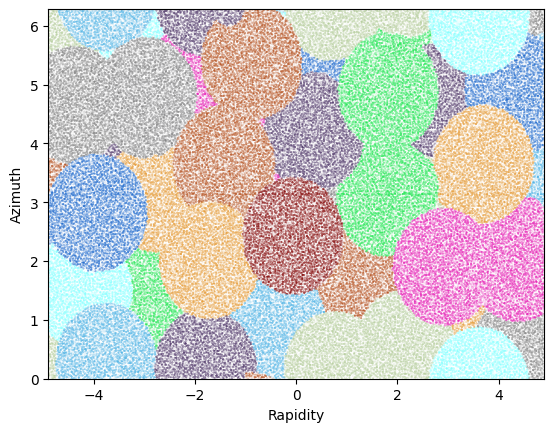

In [18]:
### color for akt

print("akt jet info ... ");
print("idx\ty\t\tphi\t\tpt\t\tn constituents");
# print("        indices of constituents\n\n");

# set first color to red
r = 0.5
g = 0
b = 0

# print out the details for each jet
for j in akt_jets:
    current_color = (r,g,b, 0.1)
    # get the constituents of the jet
    constituents = fj.sorted_by_pt(j.constituents())
    # print(0,"\t",
    #       "%0.4f"%j.rap(), "\t",
    #       "%0.4f"%j.phi(),"\t",
    #       "%0.4f"%j.perp(),"\t",
    #       len(constituents))
    
    # print("\nConstituent info:       ");
    # for c in constituents:
    #     print(0,"\t",
    #           "%0.4f"%c.rap(),"\t",
    #           "%0.4f"%c.phi(),"\t",
    #           "%0.4f"%c.perp(),"\t",
    #          );

    zf = 2

    # avg_rap = sum([c.rap() for c in constituents]) / len(constituents)
    # avg_phi = sum([c.phi() for c in constituents]) / len(constituents)
    avg_rap = sum([p.rap() for p in particles]) / len(particles)
    avg_phi = sum([p.phi() for p in particles]) / len(particles) # changed to particles rather than constituents to show whole event
    
    # plt.scatter([c.rap()-avg_rap for c in constituents],
    #             [c.phi()-avg_phi for c in constituents],
    #             s=[c.perp()*zf for c in constituents],
    #             # s=[np.log(c.perp())*zf for c in constituents],
    #             color='purple')
    plt.scatter([c.rap() for c in constituents],
                [c.phi() for c in constituents],
                s=[c.perp()*zf for c in constituents],
                color=[(r,g,b, (nc/len(constituents))) for nc,c in enumerate(constituents)])
    
    plt.xlim(-4.9,4.9)
    plt.ylim(0, 2*np.pi) # changed from 0.4 to show whole event
    plt.ylabel('Azimuth')
    plt.xlabel('Rapidity')

    # change to next color
    r = (r+0.2) % 1
    g = (g+0.3) % 1
    b = (b+0.1) % 1
    
plt.show()

ca jet info ... 
idx	y		phi		pt		n constituents


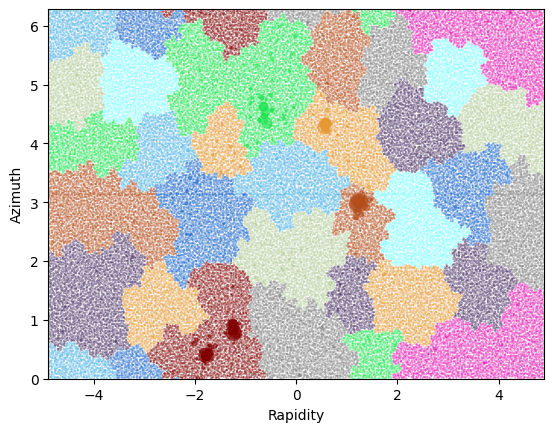

In [13]:
### color for ca

print("ca jet info ... ");
print("idx\ty\t\tphi\t\tpt\t\tn constituents");
# print("        indices of constituents\n\n");

# set first color to red
r = 0.5
g = 0
b = 0

# print out the details for each jet
for j in ca_jets:
    current_color = (r,g,b,0.5)
    # get the constituents of the jet
    constituents = fj.sorted_by_pt(j.constituents())
    # print(0,"\t",
    #       "%0.4f"%j.rap(), "\t",
    #       "%0.4f"%j.phi(),"\t",
    #       "%0.4f"%j.perp(),"\t",
    #       len(constituents))
    
    # print("\nConstituent info:       ");
    # for c in constituents:
    #     print(0,"\t",
    #           "%0.4f"%c.rap(),"\t",
    #           "%0.4f"%c.phi(),"\t",
    #           "%0.4f"%c.perp(),"\t",
    #          );

    zf = 2

    # avg_rap = sum([c.rap() for c in constituents]) / len(constituents)
    # avg_phi = sum([c.phi() for c in constituents]) / len(constituents)
    avg_rap = sum([p.rap() for p in particles]) / len(particles)
    avg_phi = sum([p.phi() for p in particles]) / len(particles) # changed to particles rather than constituents to show whole event
    
    # plt.scatter([c.rap()-avg_rap for c in constituents],
    #             [c.phi()-avg_phi for c in constituents],
    #             s=[c.perp()*zf for c in constituents],
    #             # s=[np.log(c.perp())*zf for c in constituents],
    #             color='purple')
    plt.scatter([c.rap() for c in constituents],
                [c.phi() for c in constituents],
                s=[c.perp()*zf for c in constituents],
                color=current_color)
    
    plt.xlim(-4.9,4.9)
    plt.ylim(0, 2*np.pi) # changed from 0.4 to show whole event
    plt.ylabel('Azimuth')
    plt.xlabel('Rapidity')

    # change to next color
    r = (r+0.2) % 1
    g = (g+0.3) % 1
    b = (b+0.1) % 1
    
plt.show()